In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


In [5]:
data = pd.read_csv("../data_desafio2.csv")
data.head(3)

,property_type,place_name,state_name,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,description,title,ambientes,gimnasio,terraza,patio,parrilla,salon,laundry,pileta,cochera,tren_subte,cantidad_amenities
0,PH,Mataderos,Capital Federal,62000.0,55.0,40.0,NaN,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,2.0,0,0,1,0,0,0,0,0,0,1
1,apartment,Mataderos,Capital Federal,72000.0,55.0,55.0,NaN,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,2.0,0,0,0,0,0,0,0,0,0,0
2,PH,Liniers,Capital Federal,95000.0,NaN,NaN,NaN,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,3.0,0,0,1,0,0,0,0,0,0,1


In [3]:
data.dtypes

property_type             object
place_name                object
state_name                object
price_aprox_usd          float64
surface_total_in_m2      float64
surface_covered_in_m2    float64
rooms                    float64
description               object
title                     object
ambientes                float64
gimnasio                   int64
terraza                    int64
patio                      int64
parrilla                   int64
salon                      int64
laundry                    int64
pileta                     int64
cochera                    int64
tren_subte                 int64
cantidad_amenities         int64
dtype: object

Eliminamos las columnas que ya no vamos a pasar a dummies ni vamos a necesitar, como 'state_name', ya que todo este dataframe es solo de CABA

In [7]:
dfCABA = data.drop(['state_name','description', 'title', 'rooms'], axis = 1)

Dropeamos los nulos en el precio, superficie total y superficie cubierta

In [8]:
dfCABA.isnull().sum()
df = dfCABA.dropna(axis = 0, subset = ['price_aprox_usd','surface_total_in_m2','surface_covered_in_m2'])
df.shape

(26187, 16)

Sacamos las filas con nulos de nuestras columnas para la superficie

In [9]:
df.columns

Index(['property_type', 'place_name', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'ambientes', 'gimnasio', 'terraza', 'patio',
       'parrilla', 'salon', 'laundry', 'pileta', 'cochera', 'tren_subte',
       'cantidad_amenities'],
      dtype='object')

Quitamos los Outliers

In [10]:
columnas = ['price_aprox_usd', 'surface_total_in_m2','surface_covered_in_m2','ambientes']
df_reducido = df[columnas]

# Vemos la correlación entre variables no dummyes
print(df_reducido.corr())

# Quitamos los Outliers de las variables seleccionadas no dummyes
x =  df.price_aprox_usd
mask = x.between(x.quantile(.05),x.quantile(.95))
x =  df.surface_total_in_m2
mask_sup_total = x.between(x.quantile(.05),x.quantile(.95))
x =  df.surface_covered_in_m2
mask_sup_cubierta = x.between(x.quantile(.05),x.quantile(.95))
datos = df[mask & mask_sup_total & mask_sup_cubierta]

# Revisamos como era el df original, las mascara utilizada para quitar outliers y el tamaño del df final "datos"
print(df.shape)
print(mask.sum())
print(datos.price_aprox_usd.shape)
print(datos.surface_total_in_m2 .shape)
print(datos.surface_covered_in_m2.shape)
print('Luego de quitar outliers, el df queda ' + str(datos.shape))

                       price_aprox_usd  surface_total_in_m2  \
price_aprox_usd               1.000000             0.098620   
surface_total_in_m2           0.098620             1.000000   
surface_covered_in_m2         0.083445             0.996641   
ambientes                     0.235057             0.038282   

                       surface_covered_in_m2  ambientes  
price_aprox_usd                     0.083445   0.235057  
surface_total_in_m2                 0.996641   0.038282  
surface_covered_in_m2               1.000000   0.034625  
ambientes                           0.034625   1.000000  
(26187, 16)
23582
(21920,)
(21920,)
(21920,)
Luego de quitar outliers, el df queda (21920, 16)


Revisamos los nulos en cada columna antes de probar un modelo

In [11]:
#Todavía mantenemos los ambientes que tienen bastantes nulos (%27,8) para luego ver 
na_ratio = ((datos.isnull().sum() / len(datos))*100).sort_values(ascending = False)
print(na_ratio)
#si podemos probar un modelo en el que dropiemos los nulos y ver cuánto afecta 

ambientes                27.864964
cantidad_amenities        0.000000
tren_subte                0.000000
cochera                   0.000000
pileta                    0.000000
laundry                   0.000000
salon                     0.000000
parrilla                  0.000000
patio                     0.000000
terraza                   0.000000
gimnasio                  0.000000
surface_covered_in_m2     0.000000
surface_total_in_m2       0.000000
price_aprox_usd           0.000000
place_name                0.000000
property_type             0.000000
dtype: float64


Agrupamos en 8 zonas los valores de la columna place_name, seleccionando propuestas de divisiones de paginas de inmobiliarias. Tambien luego se pueden ver modelos que tomen como dataframe una zona en particular. 

In [12]:
barrios_caba_mapper = {
    'Abasto' : 'Eje central',
    'Agronomía' : 'Corredor Noroeste',
    'Almagro' : 'Eje central',
    'Balvanera' : 'Eje central',
    'Barracas' : 'Sur Este',
    'Barrio Norte' : 'Corredor Norte',
    'Belgrano' : 'Corredor Norte',
    'Boca' : 'Sur Este',
    'Boedo' : 'Eje central',
    'Capital Federal' : 'Sin determinar zona',
    'Catalinas' : 'Corredor Norte',
    'Centro / Microcentro' : 'Macrocentro',
    'Chacarita' : 'Corredor Noroeste',
    'Coghlan' : 'Corredor Norte',
    'Constitución' : 'Sur Este',
    'Floresta' : 'Oeste',
    'Las Cañitas' : 'Corredor Norte',
    'Liniers' : 'Oeste',
    'Monserrat' : 'Macrocentro',
    'Monte Castro' : 'Noroeste',
    'Nuñez' : 'Corredor Norte',
    'Once' : 'Eje central',
    'Palermo' : 'Corredor Norte',
    'Palermo Chico' : 'Corredor Norte',
    'Palermo Hollywood' : 'Corredor Norte',
    'Palermo Soho' : 'Corredor Norte',
    'Palermo Viejo' : 'Corredor Norte',
    'Parque Avellaneda' : 'Oeste',
    'Parque Centenario' : 'Eje central',
    'Parque Chacabuco' : 'Eje central',
    'Parque Chas' : 'Corredor Noroeste',
    'Parque Patricios' : 'Sur Este',
    'Paternal' : 'Corredor Noroeste',
    'Puerto Madero' : 'Macrocentro',
    'Recoleta' : 'Corredor Norte',
    'Saavedra' : 'Corredor Norte',
    'San Cristobal' : 'Sur Este',
    'San Nicolás' : 'Macrocentro',
    'San Telmo' : 'Macrocentro',
    'Tribunales' : 'Macrocentro',
    'Velez Sarsfield' : 'Oeste',
    'Versalles' : 'Oeste',
    'Villa Crespo' : 'Corredor Noroeste',
    'Villa del Parque' : 'Noroeste',
    'Villa General Mitre' : 'Noroeste',
    'Villa Lugano' : 'Sur',
    'Villa Luro' : 'Oeste',
    'Villa Ortuzar' : 'Corredor Noroeste',
    'Villa Pueyrredón' : 'Noroeste',
    'Villa Real' : 'Oeste',
    'Villa Riachuelo' : 'Sur',
    'Villa Santa Rita' : 'Noroeste',
    'Villa Soldati' : 'Sur',
    'Villa Urquiza' : 'Corredor Noroeste', 
    'Caballito' : 'Eje central',
    'Colegiales' : 'Corredor Norte',
    'Congreso' : 'Macrocentro',
    'Flores' : 'Eje central',
    'Mataderos' : 'Oeste',
    'Pompeya' : 'Sur',
    'Retiro' : 'Corredor Norte',
    'Villa Devoto' : 'Noroeste'
}

# barrios_caba_mapper

In [13]:
#creamos la columna zonas que va a dividir en 8 zonas inmobiliarias la capital
datos['zonas'] = datos['place_name'].map(barrios_caba_mapper)
datos.columns


/home/julian/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Index(['property_type', 'place_name', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'ambientes', 'gimnasio', 'terraza', 'patio',
       'parrilla', 'salon', 'laundry', 'pileta', 'cochera', 'tren_subte',
       'cantidad_amenities', 'zonas'],
      dtype='object')

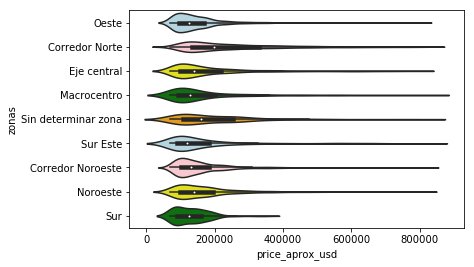

In [14]:
# Revisamos que las zonas que creamos representen los rangos y valores de los barrios 
palette_suburb = ["lightblue", "pink", "yellow", "green", "orange"]
sns.violinplot("price_aprox_usd", "zonas", data=datos, palette = palette_suburb)

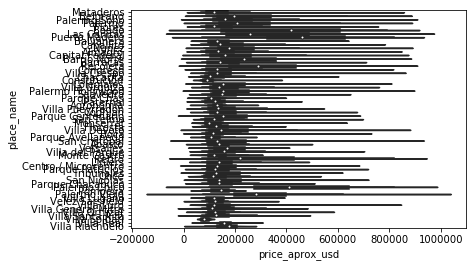

In [15]:
sns.violinplot("price_aprox_usd", "place_name", data=datos, palette = palette_suburb, height=20)

Creamos un nuevo dataframe que genere dummies de todas las variables categóricas 

In [16]:
# datos.property_type.unique()
df_dummies =  pd.get_dummies(datos, drop_first = True)
df_dummies.columns
# df1_dummies = df_dummies[['price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2',
#        'ambientes', 'gimnasio', 'terraza', 'patio', 'parrilla', 'salon',
#        'laundry', 'pileta', 'cochera', 'tren_subte', 'cantidad_amenities',
#        'property_type_apartment', 'property_type_house', 'property_type_store', 
#         'zonas_Corredor Norte',
#        'zonas_Eje central', 'zonas_Macrocentro', 'zonas_Noroeste',
#        'zonas_Oeste', 'zonas_Sin determinar zona', 'zonas_Sur',
#        'zonas_Sur Este']]
# df1_dummies.columns

Index(['price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2',
       'ambientes', 'gimnasio', 'terraza', 'patio', 'parrilla', 'salon',
       'laundry', 'pileta', 'cochera', 'tren_subte', 'cantidad_amenities',
       'property_type_apartment', 'property_type_house', 'property_type_store',
       'place_name_Agronomía', 'place_name_Almagro', 'place_name_Balvanera',
       'place_name_Barracas', 'place_name_Barrio Norte', 'place_name_Belgrano',
       'place_name_Boca', 'place_name_Boedo', 'place_name_Caballito',
       'place_name_Capital Federal', 'place_name_Centro / Microcentro',
       'place_name_Chacarita', 'place_name_Coghlan', 'place_name_Colegiales',
       'place_name_Congreso', 'place_name_Constitución', 'place_name_Flores',
       'place_name_Floresta', 'place_name_Las Cañitas', 'place_name_Liniers',
       'place_name_Mataderos', 'place_name_Monserrat',
       'place_name_Monte Castro', 'place_name_Nuñez', 'place_name_Once',
       'place_name_Palermo', 'place_n

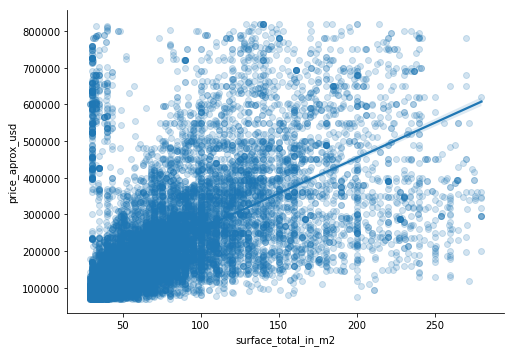

In [17]:
# datos.plot(kind='scatter', x='surface_total_in_m2', y='price_aprox_usd', alpha=0.2);
sns.lmplot(x='surface_total_in_m2', y='price_aprox_usd', data=datos, aspect=1.45,\
                                scatter_kws={'alpha':0.2});

Definimos funciones para luego probar modelos de regresión. 

Primero una regresion lineal, luego regularizada por ridge y por lasso. 

En todos los casos la funcion recibe un dataframe y las columnas features y va a imprimir las metricas (errores y R2) para cada modelo. 

Estos modelos los vamos a alimentar de diferentes formas, cambiando las columnas ingresadas como features y los hiperparámetros. 

Tambien se pueden probar diferentes filtros de partes del dataset.   

In [18]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

def train_test_error(df1,feature_cols):
    X = df1[feature_cols]
    y = df1.price_aprox_usd
    #dividimos entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    #seleccionamos el modelo
    linreg = LinearRegression()
    #entrenamos el modelo
    linreg.fit(X_train, y_train)
    #predecimos los resultados 
    y_pred = linreg.predict(X_test)
    
    #mostramos las metricas del modelo y las features utilizadas
    # print (feature_cols) Esta linea es por si queremos ver qué columnas le estamos pasando
    
    print ('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print ('MSE:', metrics.mean_squared_error(y_test, y_pred))
    print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ('R2:', metrics.r2_score(y_test, y_pred))
    print ()
    return 

train_test_error(df_dummies,feature_cols)

NameError: name 'feature_cols' is not defined

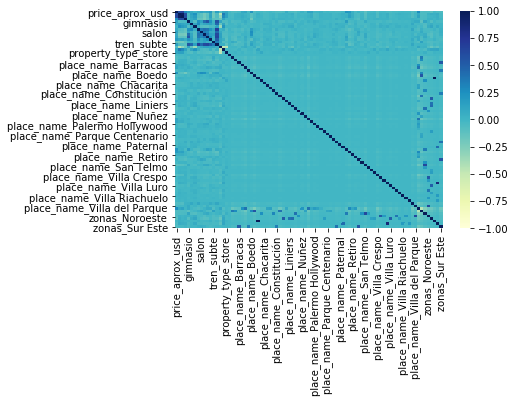

In [19]:
sns.heatmap(df_dummies.corr(), vmin=-1, vmax=1, center=0, cmap="YlGnBu");


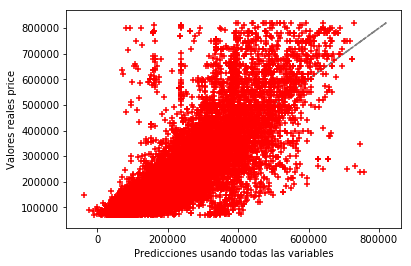

EMC: 7123373567.193622
                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     574.0
Date:                Sat, 26 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:30:37   Log-Likelihood:            -2.7975e+05
No. Observations:               21920   AIC:                         5.596e+05
Df Residuals:                   21845   BIC:                         5.602e+05
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

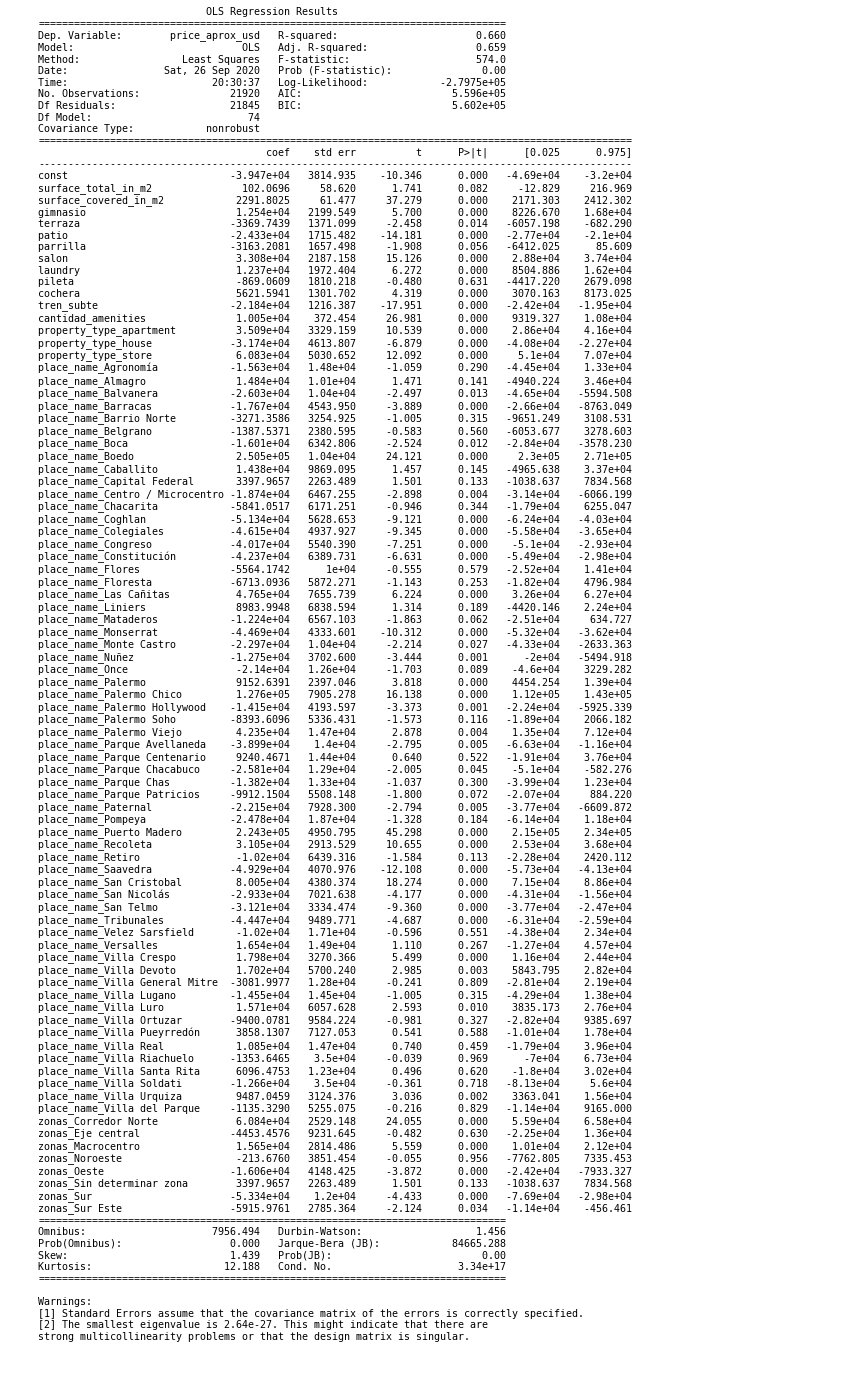

In [20]:
# Probamos con statsmodels
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

# De manera análoga a la vista en el primer ejercicio, definimos el vector de variables con la primer variable RM.


X = df_dummies[[ 'surface_total_in_m2', 'surface_covered_in_m2',
        'gimnasio', 'terraza', 'patio', 'parrilla', 'salon',
       'laundry', 'pileta', 'cochera', 'tren_subte', 'cantidad_amenities',
       'property_type_apartment', 'property_type_house', 'property_type_store',
       'place_name_Agronomía', 'place_name_Almagro', 'place_name_Balvanera',
       'place_name_Barracas', 'place_name_Barrio Norte', 'place_name_Belgrano',
       'place_name_Boca', 'place_name_Boedo', 'place_name_Caballito',
       'place_name_Capital Federal', 'place_name_Centro / Microcentro',
       'place_name_Chacarita', 'place_name_Coghlan', 'place_name_Colegiales',
       'place_name_Congreso', 'place_name_Constitución', 'place_name_Flores',
       'place_name_Floresta', 'place_name_Las Cañitas', 'place_name_Liniers',
       'place_name_Mataderos', 'place_name_Monserrat',
       'place_name_Monte Castro', 'place_name_Nuñez', 'place_name_Once',
       'place_name_Palermo', 'place_name_Palermo Chico',
       'place_name_Palermo Hollywood', 'place_name_Palermo Soho',
       'place_name_Palermo Viejo', 'place_name_Parque Avellaneda',
       'place_name_Parque Centenario', 'place_name_Parque Chacabuco',
       'place_name_Parque Chas', 'place_name_Parque Patricios',
       'place_name_Paternal', 'place_name_Pompeya', 'place_name_Puerto Madero',
       'place_name_Recoleta', 'place_name_Retiro', 'place_name_Saavedra',
       'place_name_San Cristobal', 'place_name_San Nicolás',
       'place_name_San Telmo', 'place_name_Tribunales',
       'place_name_Velez Sarsfield', 'place_name_Versalles',
       'place_name_Villa Crespo', 'place_name_Villa Devoto',
       'place_name_Villa General Mitre', 'place_name_Villa Lugano',
       'place_name_Villa Luro', 'place_name_Villa Ortuzar',
       'place_name_Villa Pueyrredón', 'place_name_Villa Real',
       'place_name_Villa Riachuelo', 'place_name_Villa Santa Rita',
       'place_name_Villa Soldati', 'place_name_Villa Urquiza',
       'place_name_Villa del Parque', 'zonas_Corredor Norte',
       'zonas_Eje central', 'zonas_Macrocentro', 'zonas_Noroeste',
       'zonas_Oeste', 'zonas_Sin determinar zona', 'zonas_Sur',
       'zonas_Sur Este']]
y = df_dummies[['price_aprox_usd']]

# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Graficamos los resultados
plt.plot(y,y, '-.', c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones usando todas las variables")
plt.ylabel("Valores reales price")
plt.show()

# Imprimimos el MSE y un resumen del modelo
print ("EMC:", mean_squared_error(y, predictions))
print (model.summary())

plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output.png')

In [21]:
from sklearn import linear_model
from sklearn.metrics import r2_score

def train_test_ridge(df1,feature_cols):
    X = df1[feature_cols]
    y = df1.price_aprox_usd
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    lm_ridge = linear_model.RidgeCV(alphas=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                        0.05, 0.1, 1, 5, 10],\
                                        normalize=True, cv=3)  
    model_r = lm_ridge.fit(X_train, y_train)
    y_pred = model_r.predict(X_test)
    print('Score model Ridge:', model_r.score(X_test, y_test))
    print ('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print ('MSE:', metrics.mean_squared_error(y_test, y_pred))
    print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ('R2:', metrics.r2_score(y_test, y_pred))
    print ('alpha', lm_ridge.alpha_)
    return



In [22]:
feature_cols = [ 'surface_total_in_m2', 'surface_covered_in_m2',
        'gimnasio', 'terraza', 'patio', 'parrilla', 'salon',
       'laundry', 'pileta', 'cochera', 'tren_subte', 'cantidad_amenities',
       'property_type_apartment', 'property_type_house', 'property_type_store',
       'place_name_Agronomía', 'place_name_Almagro', 'place_name_Balvanera',
       'place_name_Barracas', 'place_name_Barrio Norte', 'place_name_Belgrano',
       'place_name_Boca', 'place_name_Boedo', 'place_name_Caballito',
       'place_name_Capital Federal', 'place_name_Centro / Microcentro',
       'place_name_Chacarita', 'place_name_Coghlan', 'place_name_Colegiales',
       'place_name_Congreso', 'place_name_Constitución', 'place_name_Flores',
       'place_name_Floresta', 'place_name_Las Cañitas', 'place_name_Liniers',
       'place_name_Mataderos', 'place_name_Monserrat',
       'place_name_Monte Castro', 'place_name_Nuñez', 'place_name_Once',
       'place_name_Palermo', 'place_name_Palermo Chico',
       'place_name_Palermo Hollywood', 'place_name_Palermo Soho',
       'place_name_Palermo Viejo', 'place_name_Parque Avellaneda',
       'place_name_Parque Centenario', 'place_name_Parque Chacabuco',
       'place_name_Parque Chas', 'place_name_Parque Patricios',
       'place_name_Paternal', 'place_name_Pompeya', 'place_name_Puerto Madero',
       'place_name_Recoleta', 'place_name_Retiro', 'place_name_Saavedra',
       'place_name_San Cristobal', 'place_name_San Nicolás',
       'place_name_San Telmo', 'place_name_Tribunales',
       'place_name_Velez Sarsfield', 'place_name_Versalles',
       'place_name_Villa Crespo', 'place_name_Villa Devoto',
       'place_name_Villa General Mitre', 'place_name_Villa Lugano',
       'place_name_Villa Luro', 'place_name_Villa Ortuzar',
       'place_name_Villa Pueyrredón', 'place_name_Villa Real',
       'place_name_Villa Riachuelo', 'place_name_Villa Santa Rita',
       'place_name_Villa Soldati', 'place_name_Villa Urquiza',
       'place_name_Villa del Parque', 'zonas_Corredor Norte',
       'zonas_Eje central', 'zonas_Macrocentro', 'zonas_Noroeste',
       'zonas_Oeste', 'zonas_Sin determinar zona', 'zonas_Sur',
       'zonas_Sur Este']
lm_ridge = linear_model.RidgeCV(alphas=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                        0.05, 0.1, 1, 5, 10],\
                                        normalize=True, cv=3)
train_test_ridge(df_dummies,feature_cols)


Score model Ridge: 0.6567075060203013
MAE: 51094.48831455576
MSE: 7023323239.158739
RMSE: 83805.2697576873
R2: 0.6567075060203013
alpha 0.001


In [23]:

def train_test_lasso(df1,feature_cols):
    X = df1[feature_cols]
    y = df1.price_aprox_usd
    X_train, X_test, y_train, y_test = train_test_split(X, y)    
    
    lm_lasso = linear_model.LassoCV(alphas=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                        0.05, 0.1, 1, 5, 10, 15, 25],\
                                        normalize=True, cv=3)    
    model_l = lm_lasso.fit(X_train, y_train)
    y_pred = model_l.predict(X_test)
    print('Score model:', model_l.score(X_test, y_test))
    print ('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print ('MSE:', metrics.mean_squared_error(y_test, y_pred))
    print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ('R2:', metrics.r2_score(y_test, y_pred))
    print ('alpha', model_l.alpha_)
    return

In [24]:
cols1 = ['surface_total_in_m2','surface_covered_in_m2']
df_dummies.drop(columns = 'ambientes', inplace = True)

In [25]:
mask_cols = df_dummies.columns != 'price_aprox_usd'
columnas = df_dummies.columns[mask_cols]
columnas

Index(['surface_total_in_m2', 'surface_covered_in_m2', 'gimnasio', 'terraza',
       'patio', 'parrilla', 'salon', 'laundry', 'pileta', 'cochera',
       'tren_subte', 'cantidad_amenities', 'property_type_apartment',
       'property_type_house', 'property_type_store', 'place_name_Agronomía',
       'place_name_Almagro', 'place_name_Balvanera', 'place_name_Barracas',
       'place_name_Barrio Norte', 'place_name_Belgrano', 'place_name_Boca',
       'place_name_Boedo', 'place_name_Caballito',
       'place_name_Capital Federal', 'place_name_Centro / Microcentro',
       'place_name_Chacarita', 'place_name_Coghlan', 'place_name_Colegiales',
       'place_name_Congreso', 'place_name_Constitución', 'place_name_Flores',
       'place_name_Floresta', 'place_name_Las Cañitas', 'place_name_Liniers',
       'place_name_Mataderos', 'place_name_Monserrat',
       'place_name_Monte Castro', 'place_name_Nuñez', 'place_name_Once',
       'place_name_Palermo', 'place_name_Palermo Chico',
       'plac

In [26]:
train_test_lasso(df_dummies,columnas)

/home/julian/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155165916139.57812, tolerance: 22655181321.222557
  tol, rng, random, positive)
/home/julian/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158371145982.54688, tolerance: 22655181321.222557
  tol, rng, random, positive)
/home/julian/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 157334643367.15625, tolerance: 22655181321.222557
  tol, rng, random, positive)
/home/julian/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn

Score model: 0.6669337444356727
MAE: 51959.672771559046
MSE: 7112934105.677766
RMSE: 84338.21260661009
R2: 0.6669337444356727
alpha 1.0


In [30]:
X = df_dummies[feature_cols]
y = df_dummies.price_aprox_usd

X_train, X_test, y_train, y_test = train_test_split(X, y)    
cv = KFold(10, shuffle=True)
model_l = linear_model.LassoCV(normalize=True).fit(X, y)
# scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
# dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum()) 


In [31]:
model_l.intercept_

-38699.98344437071

In [32]:
model_l.coef_

array([ 8.81480758e+01,  2.30350234e+03,  1.59597778e+04,  0.00000000e+00,
       -2.06507104e+04,  2.53114437e+02,  3.65687918e+04,  1.58644332e+04,
        2.61004028e+03,  9.13910043e+03, -1.80700732e+04,  6.50821153e+03,
        3.43411318e+04, -3.12907710e+04,  5.95158329e+04, -1.29565752e+04,
        9.98030647e+03, -2.97558913e+04, -7.77943395e+03,  5.16914553e+03,
        7.24254507e+03, -5.70727740e+03,  2.45646140e+05,  9.74839914e+03,
        2.35471921e+00,  9.38957219e+03, -4.69961241e+03, -4.15439569e+04,
       -3.64726090e+04, -1.00627544e+04, -3.20070755e+04, -9.49160422e+03,
       -1.59463269e+04,  5.53084414e+04, -5.42631122e+01, -2.13828771e+04,
       -1.48186378e+04, -2.12537901e+04, -3.28018595e+03, -2.44785661e+04,
        1.77690083e+04,  1.35230791e+05, -4.51863548e+03,  0.00000000e+00,
        4.86754643e+04, -4.66494970e+04,  3.09492842e+03, -2.88225113e+04,
       -1.15091429e+04, -0.00000000e+00, -2.07612022e+04, -8.46539442e+03,
        2.52849821e+05,  

In [36]:
# Filtramos para el barrio de recoleta
mask_cols =  df_dummies['place_name_Recoleta'] == 1
df_recoleta = df_dummies[mask_cols]



,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,gimnasio,terraza,patio,parrilla,salon,laundry,pileta,...,place_name_Villa Urquiza,place_name_Villa del Parque,zonas_Corredor Norte,zonas_Eje central,zonas_Macrocentro,zonas_Noroeste,zonas_Oeste,zonas_Sin determinar zona,zonas_Sur,zonas_Sur Este
39,380000.0,196.0,196.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
58,620000.0,181.0,181.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
68,120000.0,33.0,33.0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
122,690000.0,235.0,235.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
126,378000.0,136.0,136.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31814,258000.0,104.0,104.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
31828,170000.0,71.0,71.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
32192,265000.0,73.0,73.0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
32295,325000.0,113.0,113.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [40]:
train_test_error(df_recoleta,feature_cols)

MAE: 64510.130217378566
MSE: 8188740260.727281
RMSE: 90491.65851462376
R2: 0.7513346566918324



In [41]:
train_test_ridge(df_recoleta,columnas)

Score model Ridge: 0.7978029756969682
MAE: 61631.990970395316
MSE: 7149457721.970552
RMSE: 84554.46600842886
R2: 0.7978029756969682
alpha 0.005


In [43]:
train_test_lasso(df_recoleta,columnas)

/home/julian/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46603153486.34619, tolerance: 1844442166.761918
  tol, rng, random, positive)
/home/julian/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1523571025549.5789, tolerance: 1844442166.761918
  tol, rng, random, positive)
/home/julian/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1329257080137.7803, tolerance: 1844442166.761918
  tol, rng, random, positive)
/home/julian/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/lin

Score model: 0.761256565288283
MAE: 59827.798935880426
MSE: 6917235099.676398
RMSE: 83169.91703540648
R2: 0.761256565288283
alpha 25.0
